In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import matplotlib as mpl

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [4]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix

In [5]:
train_data = r'C:\Users\ishan\Desktop\Ishan\Coding\Projects\MindfulMates\SentimentAnalysis\Dataset\train.txt'
test_data = r'C:\Users\ishan\Desktop\Ishan\Coding\Projects\MindfulMates\SentimentAnalysis\Dataset\test.txt'
val_data = r'C:\Users\ishan\Desktop\Ishan\Coding\Projects\MindfulMates\SentimentAnalysis\Dataset\val.txt'

In [6]:
df_train = pd.read_csv(f"{train_data}",delimiter=';',names=['text','label'])
df_val = pd.read_csv(f"{test_data}",delimiter=';',names=['text','label'])

In [7]:
df = pd.concat([df_train,df_val])
df.reset_index(inplace=True,drop=True)

In [8]:
print("Shape of the DataFrame:",df.shape)
print(df.sample(5))

Shape of the DataFrame: (18000, 2)
                                                    text    label
746    i keep these things predominantly for fix func...  sadness
2522                        i feel listless and deflated  sadness
4347   i would feel the speech is successful if its v...      joy
16993  i went to a wedding this weekend and i have to...      joy
2031   i use this day and night and sometimes when i ...  sadness


C:\Users\ishan\AppData\Local\Temp\ipykernel_11012\774262958.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df.label, palette='coolwarm')


<Axes: xlabel='count', ylabel='label'>

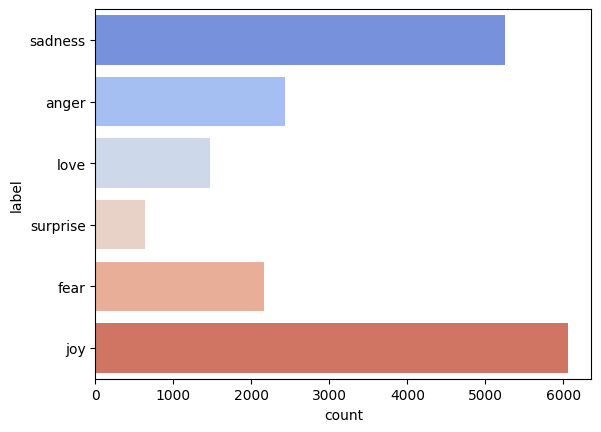

In [9]:
sns.countplot(df.label, palette='coolwarm')

In [10]:
def custom_encoder(df):
    df.replace(to_replace ="surprise", value =1, inplace=True)
    df.replace(to_replace ="love", value =1, inplace=True)
    df.replace(to_replace ="joy", value =1, inplace=True)
    df.replace(to_replace ="fear", value =0, inplace=True)
    df.replace(to_replace ="anger", value =0, inplace=True)
    df.replace(to_replace ="sadness", value =0, inplace=True)

In [11]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ishan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ishan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [13]:
#object of WordNetLemmatizer
lm = WordNetLemmatizer()
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus
corpus = text_transformation(df['text'])

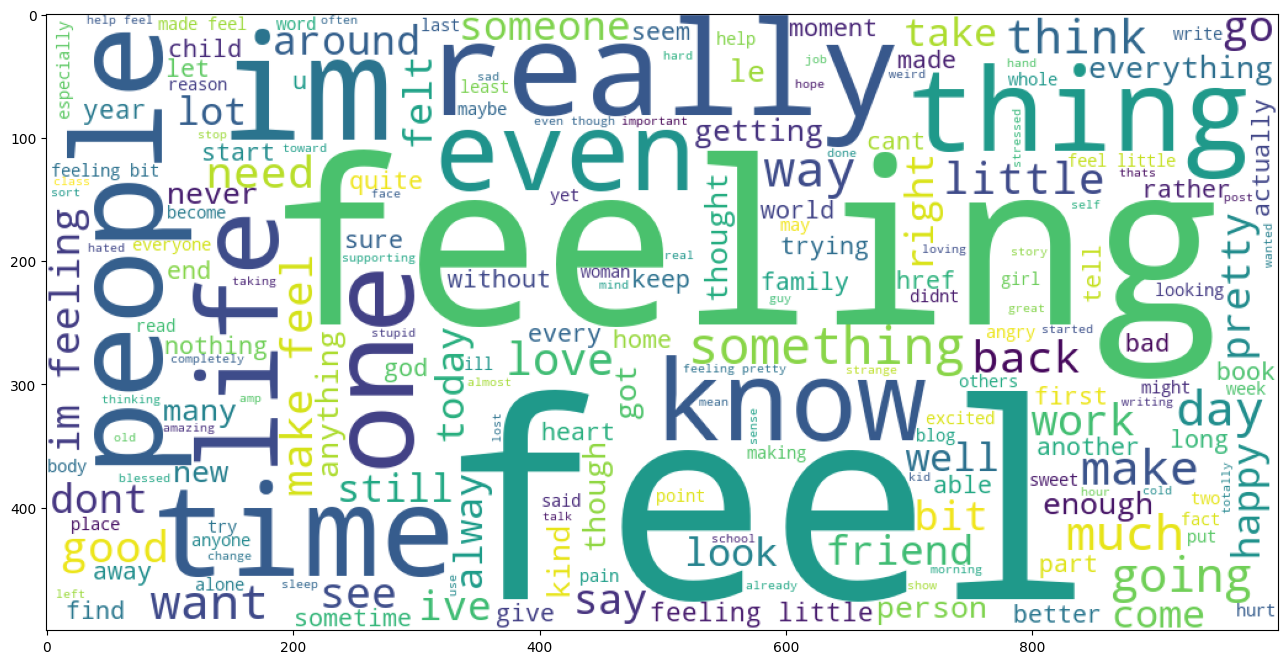

In [14]:
mpl.rcParams['figure.figsize'] = 20,8
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

In [15]:
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(corpus)
X = traindata
y = df.label

In [16]:
parameters = {'max_features': ('auto','sqrt'),
             'n_estimators': [500, 1000, 1500],
             'max_depth': [5, 10, None],
             'min_samples_split': [5, 10, 15],
             'min_samples_leaf': [1, 2, 5, 10],
             'bootstrap': [True, False]}

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=5,return_train_score=True,n_jobs=-1)
grid_search.fit(X,y)
grid_search.best_params_

In [ ]:
for i in range(432):
    print('Parameters: ',grid_search.cv_results_['params'][i])
    print('Mean Test Score: ',grid_search.cv_results_['mean_test_score'][i])
    print('Rank: ',grid_search.cv_results_['rank_test_score'][i])

In [ ]:
rfc = RandomForestClassifier(max_features=grid_search.best_params_['max_features'],
                                      max_depth=grid_search.best_params_['max_depth'],
                                      n_estimators=grid_search.best_params_['n_estimators'],
                                      min_samples_split=grid_search.best_params_['min_samples_split'],
                                      min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                                      bootstrap=grid_search.best_params_['bootstrap'])
rfc.fit(X,y)

In [ ]:
test_df = pd.read_csv(f'{test_data}',delimiter=';',names=['text','label'])
X_test,y_test = test_df.text,test_df.label
#encode the labels into two classes , 0 and 1
test_df = custom_encoder(y_test)
#pre-processing of text
test_corpus = text_transformation(X_test)
#convert text data into vectors
testdata = cv.transform(test_corpus)
#predict the target
predictions = rfc.predict(testdata)

In [ ]:
mpl.rcParams['figure.figsize'] = 10,5
plot_confusion_matrix(y_test,predictions)
acc_score = accuracy_score(y_test,predictions)
pre_score = precision_score(y_test,predictions)
rec_score = recall_score(y_test,predictions)
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(y_test,predictions)
print(cr)

In [ ]:
predictions_probability = rfc.predict_proba(testdata)
fpr,tpr,thresholds = roc_curve(y_test,predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
def expression_check(prediction_input):
    if prediction_input == 0:
        print("Input statement has Negative Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Positive Sentiment.")
    else:
        print("Invalid Statement.")

In [ ]:
# function to take the input statement and perform the same transformations we did earlier
def sentiment_predictor(input):
    input = text_transformation(input)
    transformed_input = cv.transform(input)
    prediction = rfc.predict(transformed_input)
    expression_check(prediction)

In [ ]:
input1 = ["Sometimes I just want to punch someone in the face."]
input2 = ["I bought a new phone and it's so good."]

In [ ]:
sentiment_predictor(input1)
sentiment_predictor(input2)